<a href="https://colab.research.google.com/github/BlackCurrantDS/Data-Mining/blob/master/Blood_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import PIL
import PIL.Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Loading dataset

In [43]:
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256)
    )
validation_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST_SIMPLE/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256))
test_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TEST/',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(256, 256))

Found 9977 files belonging to 4 classes.
Found 71 files belonging to 4 classes.
Found 2487 files belonging to 4 classes.


In [44]:
#classes in training data
class_names = train_ds.class_names
print(class_names)

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


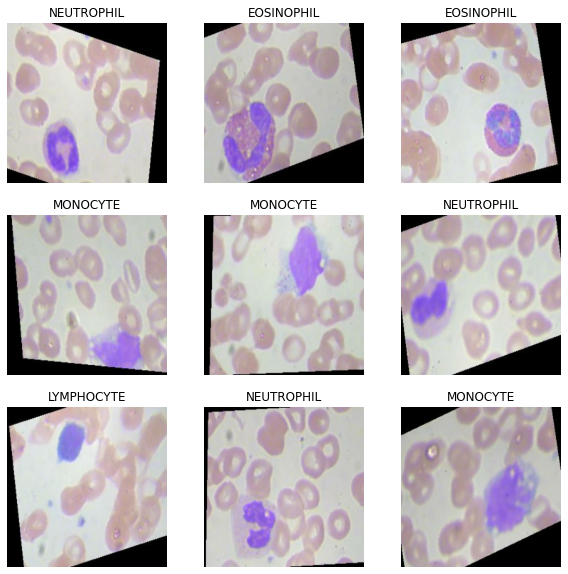

In [45]:
#checking first 10 images from training set

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

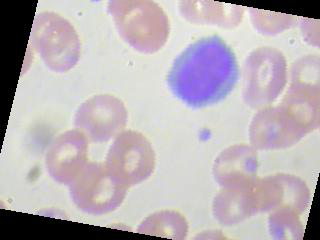

In [46]:
#randomly selecting a sample from LYMPHOCYTE
image_lymp = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/LYMPHOCYTE/_0_204.jpeg'
get_image_lymp= PIL.Image.open(image_lymp)
get_image_lymp

I can't quite find a difference between LYMPHOCYTE and MONOCYTE, so printing a random sample of MONOCYTE to find clear difference.

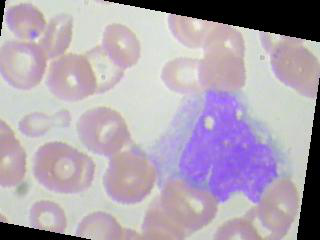

In [47]:
#randomly selecting a sample from MONOCYTE
image_mono = '/content/drive/MyDrive/Blood Cell classification/dataset2-master/dataset2-master/images/TRAIN/MONOCYTE/_0_435.jpeg'
get_image_mono = PIL.Image.open(image_mono)
get_image_mono

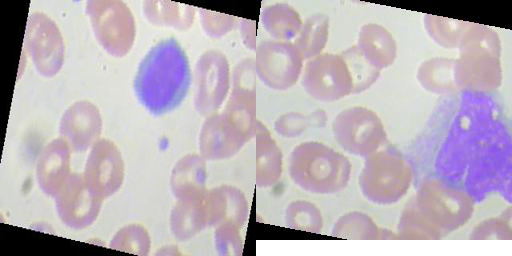

In [59]:
image1 = get_image_lymp.resize((256, 256))
image1_size = image1.size
image2_size = get_image_mono.size
new_image = Image.new('RGB',(2*image1_size[0], image1_size[1]), (256,256,256))
new_image.paste(image1,(0,0))
new_image.paste(get_image_mono,(image1_size[0],0))
new_image

LYMPHOCYTE looks littel more dense.

In [52]:
#tensorflow recommnded perfromance options for not letting dataset a bottleneck
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [60]:
#model 
num_classes = 4

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [61]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [62]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 32, 32, 64)       

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=validation_ds,
  epochs=epochs
)

Epoch 1/10
  9/312 [..............................] - ETA: 49:12 - loss: 2.4405 - accuracy: 0.2257

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()